## Setup
In this first cell, we'll load the necessary libraries.

In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

Next, we'll load our data set.

In [0]:
mdataset4 = pd.read_csv("/content/mosfet_dataset.csv", sep=",")

In [42]:
mdataset4 = mdataset4.reindex(
    np.random.permutation(mdataset4.index))
mdataset4["Output"] /= 1000.0
mdataset4

,Output,VT,VGS,VDS
10,0.0,0.6,0.8,3.8
32,0.0,0.6,0.6,0.8
5,0.0,0.6,4.2,1.6
26,0.0,0.6,0.3,0.8
12,0.0,0.6,0.8,4.0
...,...,...,...,...
9,0.0,0.6,0.7,3.7
29,0.0,0.6,0.5,0.1
23,0.0,0.6,0.2,0.9
4,0.0,0.6,4.1,1.6


In [43]:
mdataset4.describe()

,Output,VT,VGS,VDS
count,34.0,34.0,34.0,34.0
mean,0.0,0.6,1.6,1.9
std,0.0,0.0,1.6,1.5
min,0.0,0.6,0.1,0.1
25%,0.0,0.6,0.5,0.8
50%,0.0,0.6,0.9,1.5
75%,0.0,0.6,3.2,3.3
max,0.0,0.6,4.5,4.5


### Step 1: Define Features and Configure Feature Columns

In [0]:
# Define the input feature: VDS.
my_feature = mdataset4[["VDS"]]

# Configure a numeric feature column for VDS.
feature_columns = [tf.feature_column.numeric_column("VDS")]

**NOTE:** The shape of our `VDS` data is a one-dimensional array (a list of the total number of rooms for each block). This is the default shape for `numeric_column`, so we don't have to pass it as an argument.

### Step 2: Define the Target

Next, we'll define our target, which is `Output`. Again, we can pull it from our `mdataset4`:

In [0]:
# Define the label.
targets = mdataset4["Output"]

### Step 3: Configure the LinearRegressor

Next, we'll configure a linear regression model using LinearRegressor. We'll train this model using the `GradientDescentOptimizer`, which implements Mini-Batch Stochastic Gradient Descent (SGD). The `learning_rate` argument controls the size of the gradient step.



In [0]:
# Use gradient descent as the optimizer for training the model.
my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0000001)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

# Configure the linear regression model with our feature columns and optimizer.
# Set a learning rate of 0.0000001 for Gradient Descent.
linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=my_optimizer
)

### Step 4: Define the Input Function

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
  
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(buffer_size=10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

### Step 5: Train the Model

We can now call `train()` on our `linear_regressor` to train the model. We'll wrap `my_input_fn` in a `lambda`
so we can pass in `my_feature` and `targets` as arguments (see this [TensorFlow input function tutorial](https://www.tensorflow.org/get_started/input_fn#passing_input_fn_data_to_your_model) for more details), and to start, we'll
train for 100 steps.

In [0]:
_ = linear_regressor.train(
    input_fn = lambda:my_input_fn(my_feature, targets),
    steps=100
)

### Step 6: Evaluate the Model

In [49]:
# Create an input function for predictions.
# Note: Since we're making just one prediction for each example, we don't 
# need to repeat or shuffle the data here.
prediction_input_fn =lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)

# Call predict() on the linear_regressor to make predictions.
predictions = linear_regressor.predict(input_fn=prediction_input_fn)

# Format predictions as a NumPy array, so we can calculate error metrics.
predictions = np.array([item['predictions'][0] for item in predictions])

# Print Mean Squared Error and Root Mean Squared Error.
mean_squared_error = metrics.mean_squared_error(predictions, targets)
root_mean_squared_error = math.sqrt(mean_squared_error)
print("Mean Squared Error (on training data): %0.3f" % mean_squared_error)
print("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)

Mean Squared Error (on training data): 0.000
Root Mean Squared Error (on training data): 0.002


Is this a good model? How would you judge how large this error is?

Mean Squared Error (MSE) can be hard to interpret, so we often look at Root Mean Squared Error (RMSE)
instead.  A nice property of RMSE is that it can be interpreted on the same scale as the original targets.

Let's compare the RMSE to the difference of the min and max of our targets:

In [50]:
mos_out = mdataset4["Output"].min()
mos_1out = mdataset4["Output"].max()
min_max_difference = mos_1out - mos_out

print("Min. Median mos Value: %0.3f" % mos_out)
print("Max. Median mos Value: %0.3f" % mos_1out)
print("Difference between Min. and Max.: %0.3f" % min_max_difference)
print("Root Mean Squared Error: %0.3f" % root_mean_squared_error)

Min. Median mos Value: 0.001
Max. Median mos Value: 0.003
Difference between Min. and Max.: 0.002
Root Mean Squared Error: 0.002


Our error spans nearly half the range of the target values. Can we do better?

This is the question that nags at every model developer. Let's develop some basic strategies to reduce model error.

The first thing we can do is take a look at how well our predictions match our targets, in terms of overall summary statistics.

In [51]:
calibration_data = pd.DataFrame()
calibration_data["predictions"] = pd.Series(predictions)
calibration_data["targets"] = pd.Series(targets)
calibration_data.describe()

,predictions,targets
count,34.0,34.0
mean,0.0,0.0
std,0.0,0.0
min,0.0,0.0
25%,0.0,0.0
50%,0.0,0.0
75%,0.0,0.0
max,0.0,0.0


Okay, maybe this information is helpful. How does the mean value compare to the model's RMSE? How about the various quantiles?

We can also visualize the data and the line we've learned.  Recall that linear regression on a single feature can be drawn as a line mapping input *x* to output *y*.

First, we'll get a uniform random sample of the data so we can make a readable scatter plot.

In [0]:
sample = mdataset4.sample(n=10)

Next, we'll plot the line we've learned, drawing from the model's bias term and feature weight, together with the scatter plot. The line will show up red.

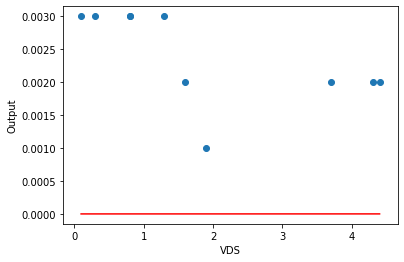

In [53]:
# Get the min and max VDS values.
x_0 = sample["VDS"].min()
x_1 = sample["VDS"].max()

# Retrieve the final weight and bias generated during training.
weight = linear_regressor.get_variable_value('linear/linear_model/VDS/weights')[0]
bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

# Get the predicted Outputs for the min and max VDS values.
y_0 = weight * x_0 + bias 
y_1 = weight * x_1 + bias

# Plot our regression line from (x_0, y_0) to (x_1, y_1).
plt.plot([x_0, x_1], [y_0, y_1], c='r')

# Label the graph axes.
plt.ylabel("Output")
plt.xlabel("VDS")

# Plot a scatter plot from our data sample.
plt.scatter(sample["VDS"], sample["Output"])

# Display graph.
plt.show()

This initial line looks way off.  See if you can look back at the summary stats and see the same information encoded there.

Together, these initial sanity checks suggest we may be able to find a much better line.

## Tweak the Model Hyperparameters
For this exercise, we've put all the above code in a single function for convenience. You can call the function with different parameters to see the effect.

In this function, we'll proceed in 10 evenly divided periods so that we can observe the model improvement at each period.

For each period, we'll compute and graph training loss.  This may help you judge when a model is converged, or if it needs more iterations.

We'll also plot the feature weight and bias term values learned by the model over time.  This is another way to see how things converge.

In [0]:
def train_model(learning_rate, steps, batch_size, input_feature="VDS"):
  """Trains a linear regression model of one feature.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `mdataset4`
      to use as input feature.
  """
  
  periods = 10
  steps_per_period = steps / periods

  my_feature = input_feature
  my_feature_data = mdataset4[[my_feature]]
  my_label = "Output"
  targets = mdataset4[my_label]

  # Create feature columns.
  feature_columns = [tf.feature_column.numeric_column(my_feature)]
  
  # Create input functions.
  training_input_fn = lambda:my_input_fn(my_feature_data, targets, batch_size=batch_size)
  prediction_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )

  # Set up to plot the state of our model's line each period.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = mdataset4.sample(n=10)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  root_mean_squared_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    predictions = linear_regressor.predict(input_fn=prediction_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    
    # Compute loss.
    root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(predictions, targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    root_mean_squared_errors.append(root_mean_squared_error)
    # Finally, track the weights and biases over time.
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = np.array([0, sample[my_label].max()])
    
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

    x_extents = (y_extents - bias) / weight
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)

  # Output a table with calibration data.
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())

  print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)

## Task 1:  Achieve an RMSE of 180 or Below

Tweak the model hyperparameters to improve loss and better match the target distribution.
If, after 5 minutes or so, you're having trouble beating a RMSE of 180, check the solution for a possible combination.

Training model...
RMSE (on training data):
  period 00 : 0.00
  period 01 : 0.00
  period 02 : 0.00
  period 03 : 0.00
  period 04 : 0.00
  period 05 : 0.00
  period 06 : 0.00
  period 07 : 0.00
  period 08 : 0.00
  period 09 : 0.00
Model training finished.


,predictions,targets
count,34.0,34.0
mean,0.0,0.0
std,0.0,0.0
min,0.0,0.0
25%,0.0,0.0
50%,0.0,0.0
75%,0.0,0.0
max,0.0,0.0


Final RMSE (on training data): 0.00


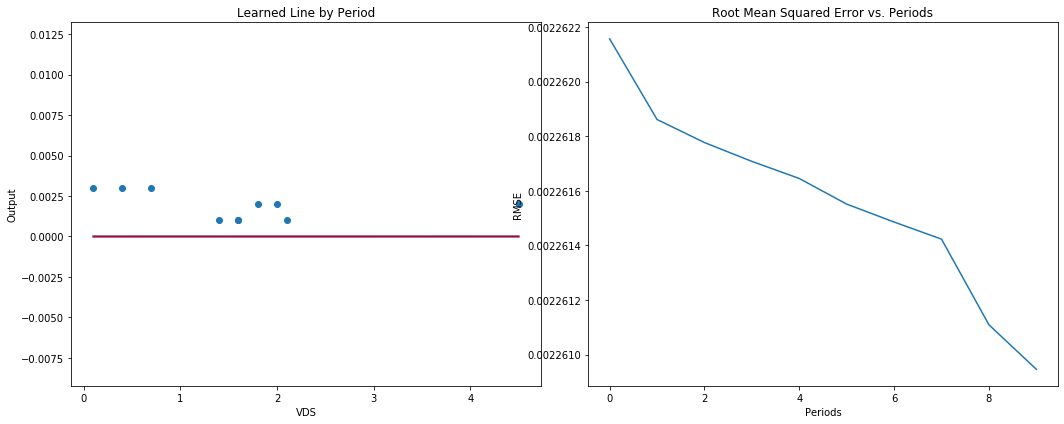

In [55]:
train_model(
    learning_rate=0.00001,
    steps=4,
    batch_size=1
)

Training model...
RMSE (on training data):
  period 00 : 0.00
  period 01 : 0.00
  period 02 : 0.00
  period 03 : 0.00
  period 04 : 0.00
  period 05 : 0.00
  period 06 : 0.00
  period 07 : 0.00
  period 08 : 0.00
  period 09 : 0.00
Model training finished.


,predictions,targets
count,34.0,34.0
mean,0.0,0.0
std,0.0,0.0
min,0.0,0.0
25%,0.0,0.0
50%,0.0,0.0
75%,0.0,0.0
max,0.0,0.0


Final RMSE (on training data): 0.00


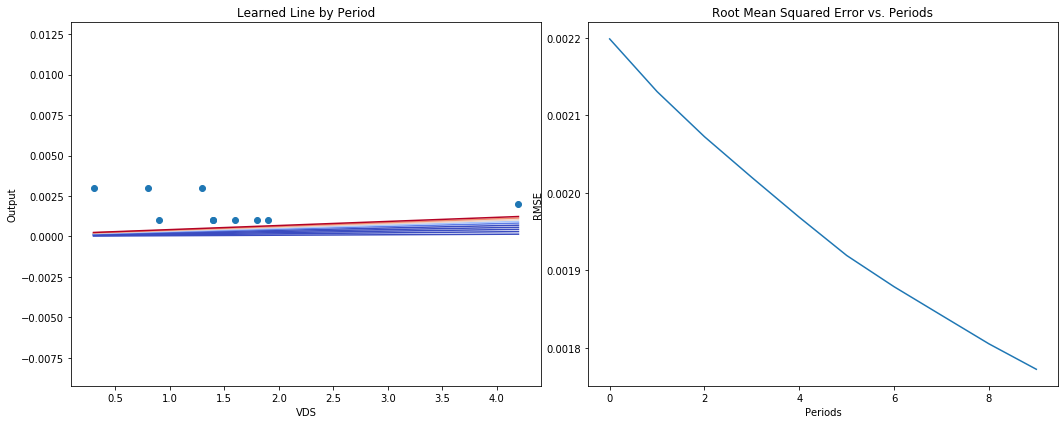

In [56]:
train_model(
    learning_rate=0.00002,
    steps=500,
    batch_size=5
)

This is just one possible configuration; there may be other combinations of settings that also give good results. Note that in general, this exercise isn't about finding the *one best* setting, but to help build your intutions about how tweaking the model configuration affects prediction quality.

### Is There a Standard Heuristic for Model Tuning?

This is a commonly asked question. The short answer is that the effects of different hyperparameters are data dependent. So there are no hard-and-fast rules; you'll need to test on your data.

That said, here are a few rules of thumb that may help guide you:

 * Training error should steadily decrease, steeply at first, and should eventually plateau as training converges.
 * If the training has not converged, try running it for longer.
 * If the training error decreases too slowly, increasing the learning rate may help it decrease faster.
   * But sometimes the exact opposite may happen if the learning rate is too high.
 * If the training error varies wildly, try decreasing the learning rate.
   * Lower learning rate plus larger number of steps or larger batch size is often a good combination.
 * Very small batch sizes can also cause instability.  First try larger values like 100 or 1000, and decrease until you see degradation.

Again, never go strictly by these rules of thumb, because the effects are data dependent.  Always experiment and verify.

In [57]:
print(linear_regressor.predict(input_fn=3.5))


<generator object Estimator.predict at 0x7fd896086048>
the rigion is linear


### Solution

Click below for one possible solution.